In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
DATA_PATH = '../data/'
data = pd.read_pickle(DATA_PATH + 'train_data.pkl')

/home/kuciu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/kuciu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data

In [3]:
# sample size
k = 0.1
data = data.sample(frac=k, random_state=137)

In [4]:
# scaling data
from data_pipeline import data_pipeline

pipeline = data_pipeline()
data = pipeline.fit_transform(data)
unused_features = ['index']
data = data.drop(unused_features, axis=1)
data = data.astype(np.float32)
data['is_downstream_reconstructible'] = data['is_downstream_reconstructible'].astype(np.int64)
data.info()

# split on train and test
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

x_train = train_set.drop(['is_downstream_reconstructible'], axis=1)
y_train = train_set['is_downstream_reconstructible'].copy()

x_test = test_set.drop(['is_downstream_reconstructible'], axis=1)
y_test = test_set['is_downstream_reconstructible'].copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175435 entries, 1042314 to 366681
Data columns (total 16 columns):
is_downstream_reconstructible    175435 non-null int64
seed_chi2PerDoF                  175435 non-null float32
seed_p                           175435 non-null float32
seed_pt                          175435 non-null float32
seed_nLHCbIDs                    175435 non-null float32
seed_nbIT                        175435 non-null float32
seed_nLayers                     175435 non-null float32
seed_x                           175435 non-null float32
seed_y                           175435 non-null float32
seed_tx                          175435 non-null float32
seed_ty                          175435 non-null float32
seed_mva_value                   175435 non-null float32
seed_angle                       175435 non-null float32
seed_pr                          175435 non-null float32
seed_z_magnet                    175435 non-null float32
seed_r                        

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b252b6e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1b17c83a90>]], dtype=object)

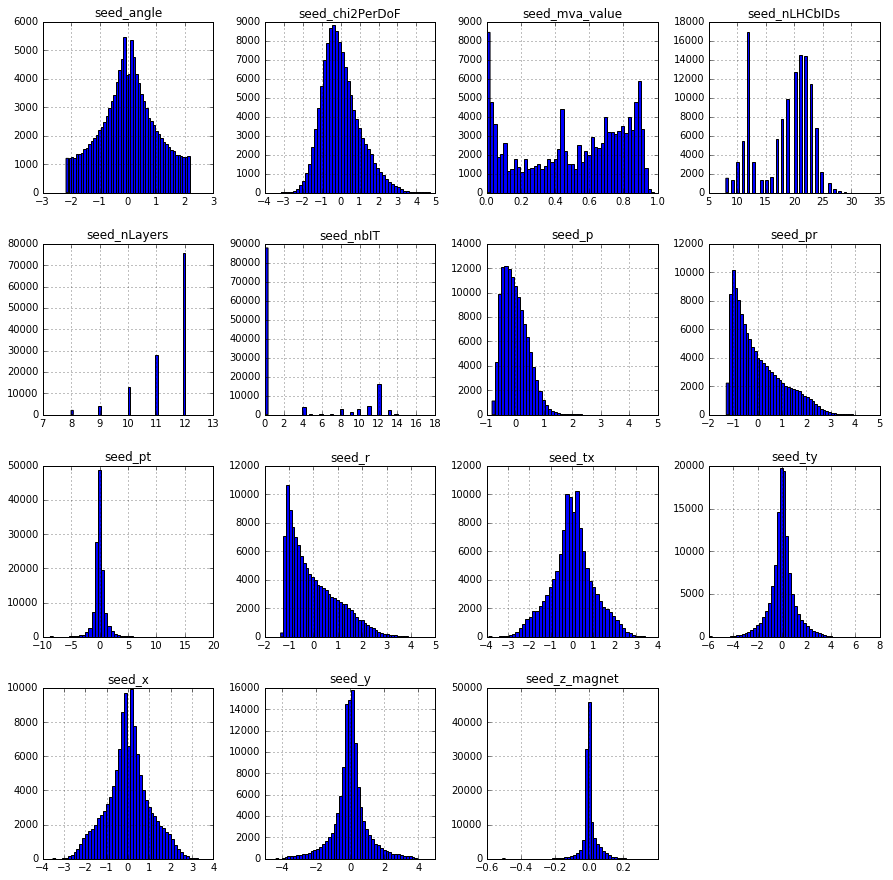

In [5]:
x_train.hist(bins=50, figsize=(15,15))

In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122804 entries, 1057331 to 103571
Data columns (total 15 columns):
seed_chi2PerDoF    122804 non-null float32
seed_p             122804 non-null float32
seed_pt            122804 non-null float32
seed_nLHCbIDs      122804 non-null float32
seed_nbIT          122804 non-null float32
seed_nLayers       122804 non-null float32
seed_x             122804 non-null float32
seed_y             122804 non-null float32
seed_tx            122804 non-null float32
seed_ty            122804 non-null float32
seed_mva_value     122804 non-null float32
seed_angle         122804 non-null float32
seed_pr            122804 non-null float32
seed_z_magnet      122804 non-null float32
seed_r             122804 non-null float32
dtypes: float32(15)
memory usage: 8.0 MB


## Model

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
import keras
class KerasDNN(KerasClassifier):
    
    def __init__(self, input_shape, output_shape,
                 layers=3,
                 neurons=100,
                 activation='relu',
                 loss_metric='ce',
                 optimizer='adam',
                 batch_norm=True,
                 dropout=0.0,
                 metrics=['accuracy']
                 ):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.layers = layers
        self.neurons = neurons
        self.activation = activation
        self.loss_metric = loss_metric
        self.optimizer = optimizer
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.metrics = metrics
        
        super().__init__()
    
    def __call__(self):
        inp = keras.layers.Input(self.input_shape)

        layer = inp
        for i in range(self.layers):
            layer = keras.layers.Dense(self.neurons, activation=self.activation)(layer)
            if self.batch_norm:
                layer = keras.layers.BatchNormalization()(layer)
            if self.dropout > 0:
                layer = keras.layers.core.Dropout(self.dropout)(layer)

        layer = keras.layers.Dense(self.output_shape[-1], activation='softmax')(layer)

        model = keras.models.Model(inputs=[inp], outputs=[layer])
        model.compile(optimizer=self.optimizer, loss=self.loss_metric, metrics=self.metrics)
        self.model = model
        return model
    
    def predict_proba(self, x, **kwargs):
        return self.model.predict(x)
        
    def predict(self, x, **kwargs):
        predictions = self.predict_proba(x, **kwargs)
        return np.argmax(predictions, axis=1)
    
    

Using TensorFlow backend.


### training

In [8]:
DNNclf = KerasDNN(
    (x_train.shape[1],),
    (2,),
    neurons=10,
    loss_metric='sparse_categorical_crossentropy'
)
DNNclf.fit(
    x_train.values, y_train.values,
    epochs=10,
    validation_data=(x_test.values, y_test.values)
)

Train on 122804 samples, validate on 52631 samples
Epoch 1/10
122804/122804 [==============================] - 11s - loss: 0.5052 - acc: 0.7582 - val_loss: 0.4515 - val_acc: 0.7934
Epoch 2/10
122804/122804 [==============================] - 11s - loss: 0.4589 - acc: 0.7876 - val_loss: 0.4496 - val_acc: 0.7960
Epoch 3/10
122804/122804 [==============================] - 11s - loss: 0.4517 - acc: 0.7911 - val_loss: 0.4533 - val_acc: 0.7913
Epoch 4/10
122804/122804 [==============================] - 11s - loss: 0.4410 - acc: 0.7960 - val_loss: 0.4216 - val_acc: 0.8054
Epoch 5/10
122804/122804 [==============================] - 11s - loss: 0.4341 - acc: 0.8010 - val_loss: 0.4200 - val_acc: 0.8120
Epoch 6/10
122804/122804 [==============================] - 10s - loss: 0.4301 - acc: 0.8039 - val_loss: 0.4214 - val_acc: 0.8086
Epoch 7/10
122804/122804 [==============================] - 10s - loss: 0.4267 - acc: 0.8057 - val_loss: 0.4347 - val_acc: 0.8034
Epoch 8/10
122804/122804 [=============

In [9]:
np.sum(DNNclf.predict_proba(x_test.values[:10]), axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.00000012,  1.        ], dtype=float32)

In [10]:
DNNclf.predict(x_test.values[:10])

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [13]:
import time
import os
model_path = '../saved_models/keras_binary_clf_{}/'.format(time.ctime())

os.mkdir(model_path)
DNNclf.model.save(model_path + 'keras_model.h5')

In [44]:
import tensorflow as tf
import keras.backend as K
def export_binary_clf_as_SavedModel(keras_model, export_dir):
    K.set_learning_phase(0)
    
    inputs = tf.placeholder(tf.float32, shape=keras_model.layers[0].output.shape)
    predictions = keras_model(inputs)
    scores = tf.nn.softmax(predictions)
    classes = tf.argmax(predictions, axis=1)
    
    
    classify_signature = tf.saved_model.signature_def_utils.predict_signature_def(
        {'inputs': inputs}, {'classes': classes}
    )

    score_signature = tf.saved_model.signature_def_utils.predict_signature_def(
        {'inputs': inputs}, {'scores': scores}
    )
    if tf.saved_model.signature_def_utils.is_valid_signature(classify_signature) and tf.saved_model.signature_def_utils.is_valid_signature(score_signature):

        signature_def_map = {
            "classify":
                classify_signature,
            'predict_probability':
                score_signature
        }

    builder = tf.saved_model.builder.SavedModelBuilder(os.path.join(export_dir, 'saved_model'))

    tag_constants = [tf.saved_model.tag_constants.SERVING]
    
    builder.add_meta_graph_and_variables(
            K.get_session(),
            tag_constants,
            signature_def_map=signature_def_map,
            assets_collection=tf.get_collection(tf.GraphKeys.ASSET_FILEPATHS),
        )
    builder.save()


In [45]:
export_binary_clf_as_SavedModel(DNNclf.model, model_path)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'../saved_models/keras_binary_clf_Sat Oct 21 19:30:12 2017/saved_model/saved_model.pb'
